In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25"
import sys
import time
import h5py
import numpy as np
from pathlib import Path
from utils import simulation2d as project
from flowrec.data import data_partition, DataMetadata
import flowrec.training_and_states as train
from flowrec.training_and_states import TrainingState
from flowrec import losses
import flowrec.physics_and_derivatives as derivatives
from flowrec.models.cnn import Model
import jax 
import jax.numpy as jnp
from jax import lax
import optax
from flowrec._typing import Array, Scalar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from jax.tree_util import tree_map, Partial
from utils.system import on_which_platform
import chex

train_test_split = [600,100,100]
# train_test_split = [600,100,100]
learning_rate = 0.0001
mlp_layers = [] # size of the intermediate layers
cnn_channels = [32,16,3]
cnn_filter = [(3,3)]
dropout_rate = 0.00
regularisation_strength = 0.0000
epochs = 80000
nb_batches = 6
re = 100
data_dir = Path("./local_data/re"+str(re))
dt = 0.0002*625
dx = 12/512
dy = 4/128
sensor_slicing_space = np.s_[::15,::10] # taking points as sensors
weighting = [0.1,0.9] # weighting terms for [physics,sensors]
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
######### delete last rows
x = x[:,:,:250,:]

# data_randseed = np.random.randint(1,1000000)
# [x_train,x_val,x_test], _ = data_partition(x,1,train_test_split,REMOVE_MEAN=False,randseed=data_randseed,SHUFFLE=False) # Do not shuffle, do not remove mean for training with physics informed loss


# [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
# [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
# [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

# triangle_base_coords = [49,80]
# pb_train = project.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
# pb_val = project.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
# pb_test = project.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

# (nt,nx,ny) = ux_train.shape
# n_base = pb_train.shape[-1]

# # information about the grid
# datainfo = DataMetadata(
#     re = re,
#     discretisation=[dt,dx,dy],
#     axis_index=[0,1,2],
#     problem_2d=True
# ).to_named_tuple()

# mlp_layers.extend([3*nx*ny])

# pb_train = np.reshape(pb_train,(train_test_split[0],-1))
# pb_val = np.reshape(pb_val,(train_test_split[1],-1))


# u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
# u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)

# # take sensor measurement
# sensor_slicing = (np.s_[:],) + sensor_slicing_space

# observed_train = u_train[sensor_slicing]
# observed_val = u_val[sensor_slicing]

# rng = jax.random.PRNGKey(np.random.randint(10,50))
# optimizer = optax.adamw(learning_rate=learning_rate,weight_decay=regularisation_strength)

# mdl = Model(mlp_layers,output_shape=(nx,ny,3),cnn_channels=cnn_channels,cnn_filters=cnn_filter,dropout_rate=dropout_rate)

In [3]:
x.shape

(3, 800, 250, 129)

In [16]:
std_all = np.std(x,axis=(1,2,3),ddof=1)
print(std_all.shape)
print(std_all)

(3,)
[0.39016105 0.45816697 0.30208391]


In [55]:
snr = 10.0
snr_l = 10.**(snr/10.)
std_n = np.sqrt(std_all**2/snr_l)
std_n

array([0.12337976, 0.14488512, 0.09552732])

In [56]:
if snr > 0.0:
    print('noise')

noise


In [47]:
noise_u = np.random.normal(scale=std_n[0],size=x[0,...].shape)
noise_v = np.random.normal(scale=std_n[1],size=x[1,...].shape)
noise_p = np.random.normal(scale=std_n[2],size=x[2,...].shape)

In [48]:
noise = np.stack([noise_u,noise_v,noise_p],axis=0)
x_noisy = x + noise

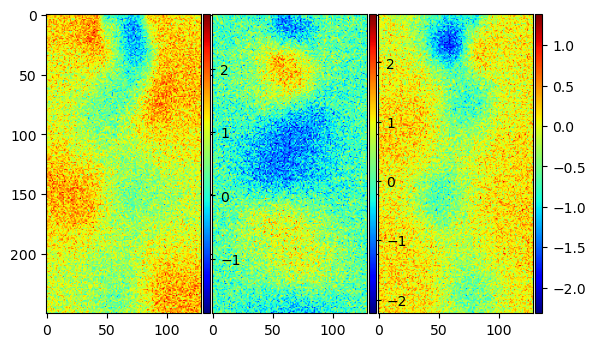

In [49]:
fig = plt.figure()
grid = ImageGrid(fig,111,(1,3),cbar_mode='each')
for ax,cax,data in zip(grid,grid.cbar_axes,x_noisy):
    im = ax.imshow(data[100,...],'jet')
    cax.colorbar(im)

In [2]:
jax.devices()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

In [21]:
on_which_platform()

cpu


In [4]:

@jax.tree_util.Partial(jax.jit,static_argnames=('axis'))
def derivative2(f:Array, h:Scalar, axis:int=0) -> Array:
    '''Second derivatives with second order central difference for interior points and second order forward/backward difference for boundaries.\n
    
    Arguments:\n
        f: array of values to differentiate.\n
        h: step size, only constant step is supported.\n
        axis: int. Which axis to take derivative.\n
    
    Returns:
        d2fdx2: array of second derivatives with the same shape as f.
    '''

    f = jnp.asarray(f)

    # try:
    #     chex.assert_axis_dimension_gteq(f,axis,4) # 
    # except AssertionError as err:
    #     logger.error('Not enough nodes in the selected axis for the numerical scheme used.')
    #     raise err

    
    # initialise empty array for output
    d2fdx2 = jnp.empty_like(f)
    
    # for slicing the input later
    slice1 = [slice(None)]*f.ndim
    slice2 = [slice(None)]*f.ndim
    slice3 = [slice(None)]*f.ndim
    slice4 = [slice(None)]*f.ndim

    # interior points
    # second order scheme used f(x+h), f(x) and f(x-h)
    # = (f(x+h) - 2f(x) + f(x-h)) / (h**2)
    slice1[axis] = slice(2,None)
    slice2[axis] = slice(1,-1)
    slice3[axis] = slice(None,-2)

    interior = (f[tuple(slice1)] - 2*f[tuple(slice2)] + f[tuple(slice3)]) / (h**2)

    # left boundary (x=0)
    # second order forward difference
    # = (2f(x) - 5f(x+h) + 4f(x+2h) - f(x+3h)) / (h**2)
    slice1[axis] = slice(0,1)
    slice2[axis] = slice(1,2)
    slice3[axis] = slice(2,3)
    slice4[axis] = slice(3,4)

    # d2fdx2 = d2fdx2.at[tuple(slice1)].set((2*f[tuple(slice1)] - 5*f[tuple(slice2)] + 4*f[tuple(slice3)] - f[tuple(slice4)]) / (h**2)) 
    left = (2*f[tuple(slice1)] - 5*f[tuple(slice2)] + 4*f[tuple(slice3)] - f[tuple(slice4)]) / (h**2)

    # right boundary (x=L)
    # second order backward difference
    # = (2f(x) - 5f(x-h) + 4f(x-2h) - f(x-3h)) / (h**2)
    slice1[axis] = slice(-1,None)
    slice2[axis] = slice(-2,-1)
    slice3[axis] = slice(-3,-2)
    slice4[axis] = slice(-4,-3)

    # d2fdx2 = d2fdx2.at[tuple(slice1)].set((2*f[tuple(slice1)] - 5*f[tuple(slice2)] + 4*f[tuple(slice3)] - f[tuple(slice4)]) / (h**2)) 
    right = (2*f[tuple(slice1)] - 5*f[tuple(slice2)] + 4*f[tuple(slice3)] - f[tuple(slice4)]) / (h**2)

    # return d2fdx2

    return jnp.concatenate((left,interior,right),axis=axis)


In [5]:

def momentum_residue_field(
    ux:Array,
    uy:Array,
    p:Array,
    datainfo,
    uz = None,
    **kwargs) -> Array:
    
    '''Calculate the momentum residue of the nondimensional Navier Stokes equation for selected velocity.
    Either 2D or 3D.\n
    
    Arguments:\n
        ux: array of velocity in x direction.\n
        uy: array of velocity in y direction.\n
        p: array of pressure.\n
        datainfo: an instance of DataMetadata.\n
        uz: array of velocity in z direction.\n

    return:\n
        Momentum residue field, has shape [i,...], where i is the number of velocity and ... is the shape of the input velocity field (e.g. ux.shape).
    # '''

    try:
        chex.assert_equal_shape([ux,uy,p])
        u = jnp.stack((ux,uy),axis=0)
        if uz is not None:
            chex.assert_equal_shape([ux,uz])
            u = jnp.concatenate((u,uz[jnp.newaxis,...]),axis=0)
    except AssertionError as err:
        # logger.error('Cannot calculate momentum residue, input shape mismatch.')
        raise err
    # try:
    #     chex.assert_rank(u,[2+u.shape[0]])
    # except AssertionError as err:
    #     logger.error(f'Cannot calculate momentum, number of velocities does not match the number of dimensions.')
    #     raise err

    
    step_space = datainfo.discretisation[1:]
    axis_space = datainfo.axis_index[1:]
    

    ## Define internal functions
    v_derivative1 = jax.vmap(derivatives.derivative1,(0,None,None),0)
    v_derivative2 = jax.vmap(derivative2,(0,None,None),0)
    
    # function that applies a function to inn, and x,y,z in order
    def _didj(de_fun,inn):
        didj_T = de_fun(inn,datainfo.dx,datainfo.axx).reshape((-1,)+inn.shape)
        for i in range (1,u.shape[0]):
            didj_T = jnp.concatenate(
                (
                didj_T,
                de_fun(inn,step_space[i],axis_space[i]).reshape((-1,)+inn.shape)
                ),
                axis=0
            )
        return didj_T # for de_fun = v_derivative1 and inn=u -> [j,i,t,x,y,z]
    

    ## calculate derivatives
    dui_dt = v_derivative1(u,datainfo.dt,datainfo.axt) # [i,t,x,y,z]

    # # output convection terms
    # (u*du/dx + v*du/dy,
    #  u*dv/dx + v*dv/dy)
    dui_dxj_T = _didj(v_derivative1,u)
    ududx_i = jnp.einsum('j..., ji... -> i...', u, dui_dxj_T) # [i,t,x,y,z]

    dpdx_i = _didj(derivatives.derivative1,p) #[i,t,x,y,z]

    # # output second derivatives
    # ((d2u/dx2, d2u/dy2),
    #  (d2v/dx2, d2v/dy2))
    d2ui_dxj2 = _didj(v_derivative2,u)
    d2udx2_i = jnp.einsum('ji... - > i...', d2ui_dxj2) # [i,t,x,y,z]

    residue = dui_dt + ududx_i + dpdx_i - (d2udx2_i/datainfo.re)
    
    return residue

In [6]:
%%timeit
mom_field = momentum_residue_field(
                    ux=u_train[...,0],
                    uy=u_train[...,1],
                    p=u_train[...,2],
                    datainfo=datainfo) # [i,t,x,y]

158 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
mom_field = derivatives.momentum_residue_field(
                    ux=u_train[...,0],
                    uy=u_train[...,1],
                    p=u_train[...,2],
                    datainfo=datainfo) # [i,t,x,y]

161 ms ± 4.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
new_jit = jax.jit(Partial(momentum_residue_field,datainfo=datainfo))
old_jit = jax.jit(Partial(derivatives.momentum_residue_field,datainfo=datainfo))

In [51]:
%timeit mom_field = new_jit(ux=u_train[...,0],uy=u_train[...,1],p=u_train[...,2]).block_until_ready() # [i,t,x,y]

132 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
%timeit mom_field = old_jit(ux=u_train[...,0],uy=u_train[...,1],p=u_train[...,2]).block_until_ready() # [i,t,x,y]

161 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
